In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from graph.graphutils import showGraph,showComparsionGraph
from dateutil.parser import parse
from utils.converterutils import addHeader
from utils.dfUtils import getDataFrame
import warnings
warnings.filterwarnings("ignore")
import time

In [2]:
## Load Test Data

In [3]:
app = pd.read_csv('../../test_data/fds_seasonality.csv')
app_error = pd.read_csv('../../test_data/fds_error.csv')
iam_memory = pd.read_csv('../../test_data/iam_memory.csv')
iam_memory.head(2)

,timestamp,y
0,1547837640,354515.2000
1,1547837700,255634.4889


In [4]:
## Convert to data fromat and plot graph

In [5]:
lstm, lstm_display = getDataFrame(app, True)

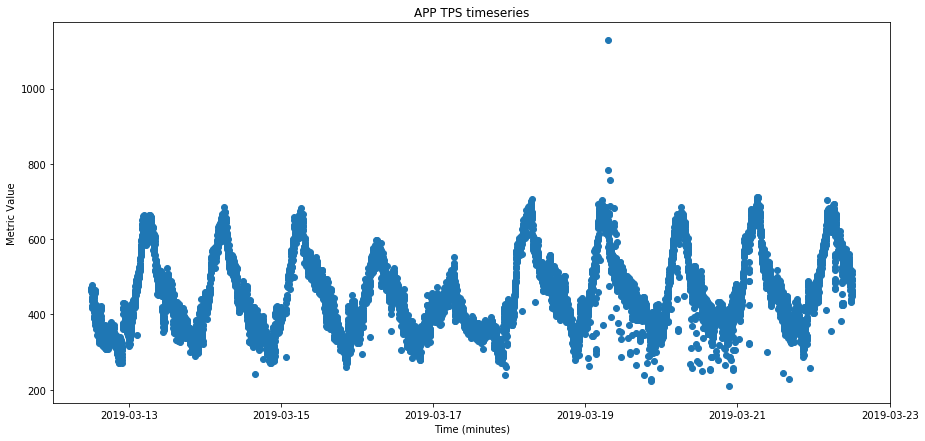

In [6]:
showGraph("APP TPS",lstm_display)

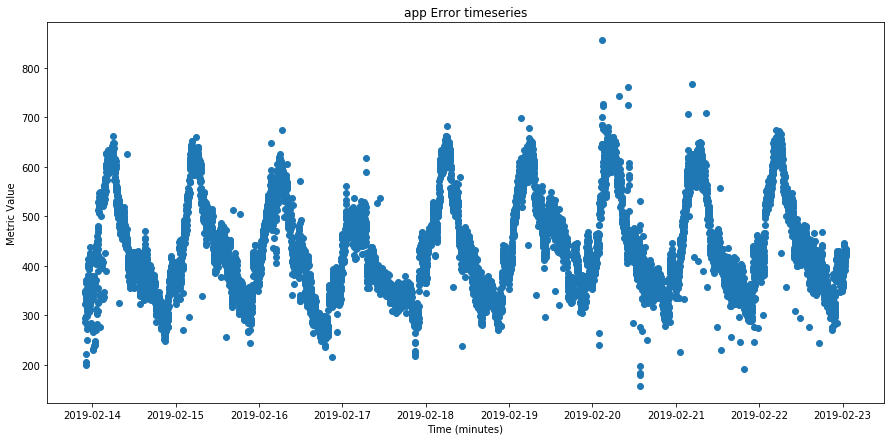

In [7]:
lstm1, lstm1_display = getDataFrame(app_error, True)
showGraph("app Error",lstm1_display)

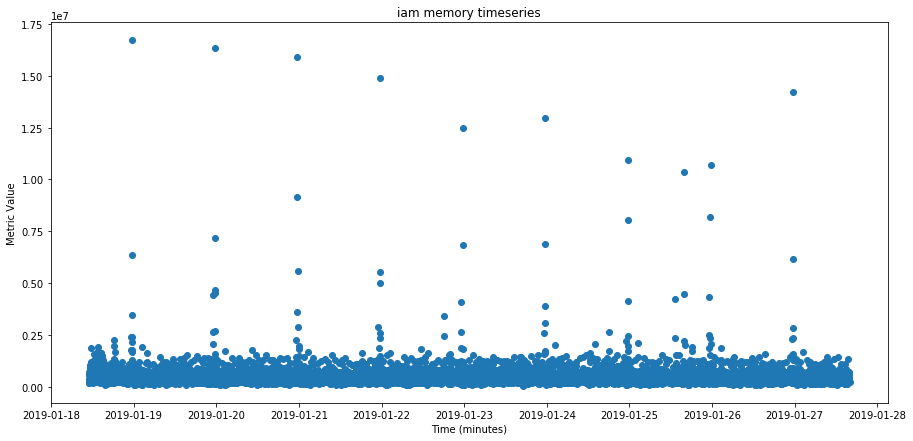

In [8]:
gussian, gussian1_display = getDataFrame(iam_memory, True)   
   
showGraph("iam memory", gussian1_display)

In [9]:
## Predict Model

In [10]:
from  mlalgms.evaluator import ts_train_test_split

In [11]:
train_lstm,test_lstm = ts_train_test_split(lstm,0.75)
train_lstm1,test_lstm1 = ts_train_test_split(lstm1,0.75 )
train_gussian,test_gussian = ts_train_test_split(gussian,0.75 )

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_lstm['y'] = scaler.fit_transform(train_lstm) 
test_lstm['y'] =  scaler.fit_transform(test_lstm) 
train_lstm1['y'] = scaler.fit_transform(train_lstm1) 
test_lstm1['y'] =  scaler.fit_transform(test_lstm1) 
train_gussian['y'] = scaler.fit_transform(train_gussian) 
test_gussian['y'] =  scaler.fit_transform(test_gussian)

In [13]:
## Data preparation, create, compile and predict model

In [14]:
from mlalgms.kerasdeeplearning import create_datasets,createModel, compileModel, predictModel
from mlalgms.tsutils import mergeResult
from mlalgms.evaluator import mape

Using TensorFlow backend.


In [15]:
LAG = 3
HORIZON =1
y_train_lstm , X_train_lstm = create_datasets (train_lstm,lag=LAG)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], LAG, 1)
y_test_lstm, X_test_lstm = create_datasets (test_lstm,lag=LAG)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], LAG, 1)

In [16]:
LATENT_DIM = 5
start = time.time()
model = createModel(mymodel='GRU', latentDim=LATENT_DIM, lag=LAG, layer=1)
print ("Time Spent", time.time() - start, "seconds.")
model.summary()

Time Spent 0.28412532806396484 seconds.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 105       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [17]:
start = time.time()
historical_lstm = compileModel(model,X_train_lstm,y_train_lstm, batchSize=100,epochs=200,learning_rate = 0.01, validation_split_rate =0.15)
print ("Time Spent", time.time() - start, "seconds.")

Train on 7049 samples, validate on 1245 samples
Epoch 1/200
7049/7049 [==============================] - 1s 122us/step - loss: 0.0031 - val_loss: 0.0027
Epoch 2/200
7049/7049 [==============================] - 0s 29us/step - loss: 5.3726e-04 - val_loss: 0.0020
Epoch 3/200
7049/7049 [==============================] - 0s 26us/step - loss: 3.6765e-04 - val_loss: 0.0021
Time Spent 1.9529879093170166 seconds.


In [18]:
start = time.time()
predictions_lstm = predictModel(model, X_test_lstm)
print ("Time Spent", time.time() - start, "seconds.")

Time Spent 0.26476478576660156 seconds.


In [19]:
predictions_lstm.shape

(2763, 1)

In [20]:
merge_lstm_df = mergeResult(test_lstm,y_test_lstm,predictions_lstm)

In [21]:
merge_lstm_df.head(2)

,timestamp,h,prediction,actual
0,1553085300,t+1,0.758307,0.859583
1,1553085360,t+1,0.787519,0.841865


In [22]:
## Calculate Actual vs Prediction mean absolute percentage error

In [23]:
mape(merge_lstm_df['actual'], merge_lstm_df['prediction'])

9.417801746066177

## Actual vs Prediction Graph

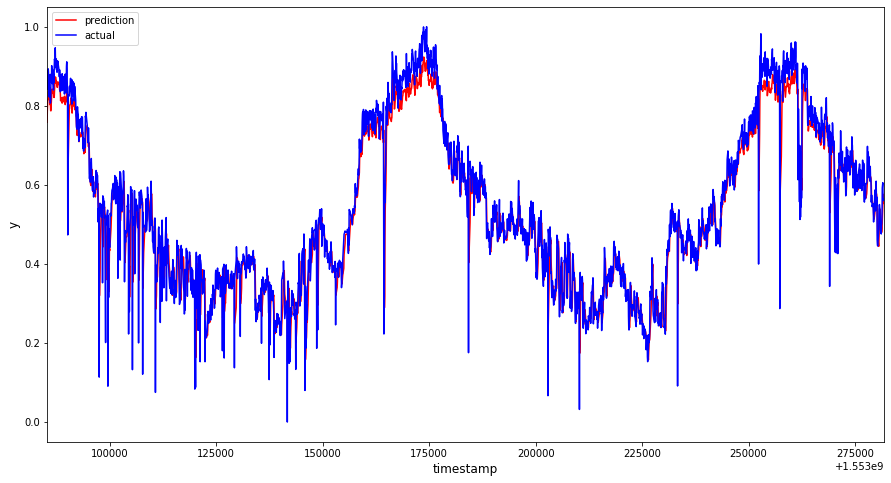

In [24]:
showComparsionGraph(merge_lstm_df)

In [ ]:
## FDS Error prediction

In [25]:
y_train_lstm1 , X_train_lstm1 = create_datasets (train_lstm1,lag=LAG)
X_train_lstm1 = X_train_lstm1.reshape(X_train_lstm1.shape[0], LAG, 1)
y_test_lstm1, X_test_lstm1 = create_datasets (test_lstm1,lag=LAG)
X_test_lstm1 = X_test_lstm1.reshape(X_test_lstm1.shape[0], LAG, 1)

In [26]:
start = time.time()
historical_lstm1 = compileModel(model,X_train_lstm1,y_train_lstm1, batchSize=100,epochs=200,learning_rate = 0.01, validation_split_rate =0.15)
print ("Time Spent", time.time() - start, "seconds.")

Train on 6365 samples, validate on 1124 samples
Epoch 1/200
6365/6365 [==============================] - 1s 143us/step - loss: 0.0012 - val_loss: 0.0024
Epoch 2/200
6365/6365 [==============================] - 0s 35us/step - loss: 0.0012 - val_loss: 0.0024
Epoch 3/200
6365/6365 [==============================] - 0s 37us/step - loss: 0.0012 - val_loss: 0.0024
Time Spent 2.2121353149414062 seconds.


In [27]:
start = time.time()
predictions_lstm1 = predictModel(model, X_test_lstm1)
print ("Time Spent", time.time() - start, "seconds.")

Time Spent 0.18882203102111816 seconds.


In [29]:
merge_lstm1_df = mergeResult(test_lstm1,y_test_lstm1,predictions_lstm1)

In [30]:
mape(merge_lstm1_df['actual'], merge_lstm1_df['prediction'])

8.095790818756754

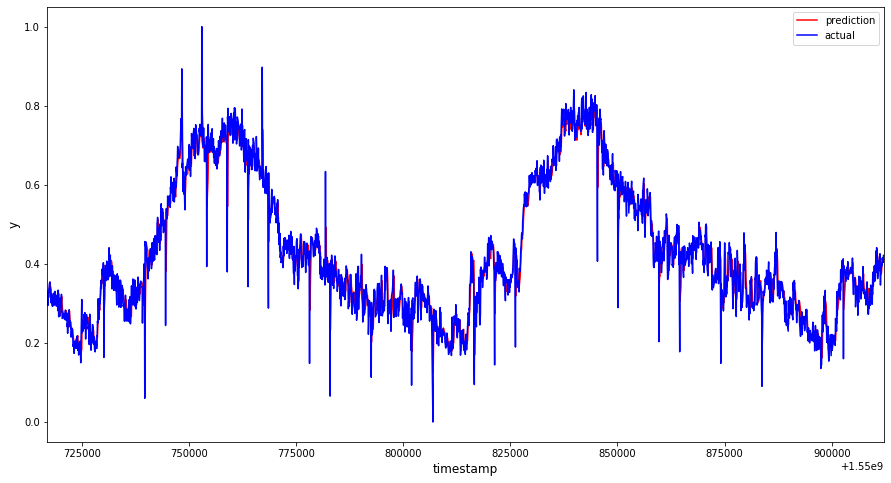

In [31]:
showComparsionGraph(merge_lstm1_df)

In [32]:
## App memory predict

In [33]:
y_train_gussian , X_train_gussian = create_datasets (train_gussian,lag=LAG)
X_train_gussian = X_train_gussian.reshape(X_train_gussian.shape[0], LAG, 1)
y_test_gussian, X_test_gussian = create_datasets (test_gussian,lag=LAG)
X_test_gussian = X_test_gussian.reshape(X_test_gussian.shape[0], LAG, 1)

In [34]:
start = time.time()
historical_gussian = compileModel(model,X_train_gussian,y_train_gussian, batchSize=100,epochs=200,learning_rate = 0.01, validation_split_rate =0.15)
print ("Time Spent", time.time() - start, "seconds.")

Train on 8370 samples, validate on 1478 samples
Epoch 1/200
8370/8370 [==============================] - 1s 138us/step - loss: 7.3943e-04 - val_loss: 4.6430e-04
Epoch 2/200
8370/8370 [==============================] - 0s 33us/step - loss: 6.9904e-04 - val_loss: 4.3879e-04
Epoch 3/200
8370/8370 [==============================] - 0s 36us/step - loss: 6.7226e-04 - val_loss: 4.2368e-04
Epoch 4/200
8370/8370 [==============================] - 0s 30us/step - loss: 6.5554e-04 - val_loss: 4.2177e-04
Epoch 5/200
8370/8370 [==============================] - 0s 36us/step - loss: 6.4256e-04 - val_loss: 4.0480e-04
Epoch 6/200
8370/8370 [==============================] - 0s 35us/step - loss: 6.3377e-04 - val_loss: 3.9742e-04
Epoch 7/200
8370/8370 [==============================] - 0s 38us/step - loss: 6.2326e-04 - val_loss: 3.9240e-04
Epoch 8/200
8370/8370 [==============================] - 0s 37us/step - loss: 6.1979e-04 - val_loss: 3.8485e-04
Epoch 9/200
8370/8370 [==============================] 

In [35]:
start = time.time()
predictions_gussian = predictModel(model, X_test_gussian)
print ("Time Spent", time.time() - start, "seconds.")

Time Spent 0.2214498519897461 seconds.


In [37]:
merge_gussian_df = mergeResult(test_gussian,y_test_gussian,predictions_gussian)

In [38]:
mape(merge_gussian_df['actual'], merge_gussian_df['prediction'])

50.76505359670169

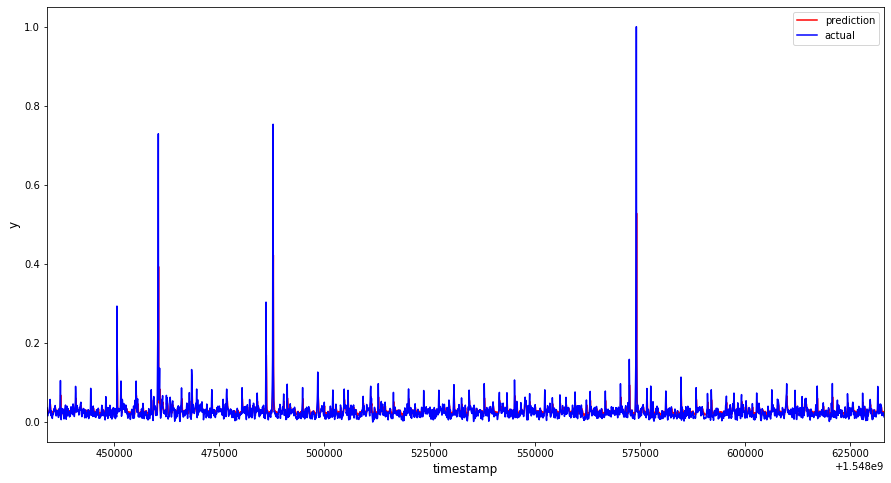

In [39]:
showComparsionGraph(merge_gussian_df)

In [40]:
LAG = 6
y_train_gussian , X_train_gussian = create_datasets (train_gussian,lag=LAG)
X_train_gussian = X_train_gussian.reshape(X_train_gussian.shape[0], LAG, 1)
y_test_gussian, X_test_gussian = create_datasets (test_gussian,lag=LAG)
X_test_gussian = X_test_gussian.reshape(X_test_gussian.shape[0], LAG, 1)

In [41]:
LATENT_DIM = 5
start = time.time()
model = createModel(mymodel='LSTM', latentDim=LATENT_DIM, lag=LAG, layer=1)
print ("Time Spent", time.time() - start, "seconds.")
model.summary()

Time Spent 0.1475527286529541 seconds.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [42]:
start = time.time()
historical_gussian = compileModel(model,X_train_gussian,y_train_gussian, batchSize=50,epochs=200,learning_rate = 0.001, validation_split_rate =0.15)
#                                 loss_func='mean_squared_error', optimizer_func='adam')
print ("Time Spent", time.time() - start, "seconds.")

Train on 8368 samples, validate on 1477 samples
Epoch 1/200
8368/8368 [==============================] - 1s 142us/step - loss: 8.1814e-04 - val_loss: 5.4387e-04
Epoch 2/200
8368/8368 [==============================] - 1s 69us/step - loss: 7.8392e-04 - val_loss: 5.3801e-04
Epoch 3/200
8368/8368 [==============================] - 1s 75us/step - loss: 7.5689e-04 - val_loss: 5.9949e-04
Time Spent 3.1760571002960205 seconds.


In [43]:
start = time.time()
predictions_gussian = predictModel(model, X_test_gussian)
print ("Time Spent", time.time() - start, "seconds.")

Time Spent 0.21686291694641113 seconds.


In [45]:
merge_gussian_df = mergeResult(test_gussian,y_test_gussian,predictions_gussian)

In [46]:
mape(merge_gussian_df['actual'], merge_gussian_df['prediction'])

88.49790236420854

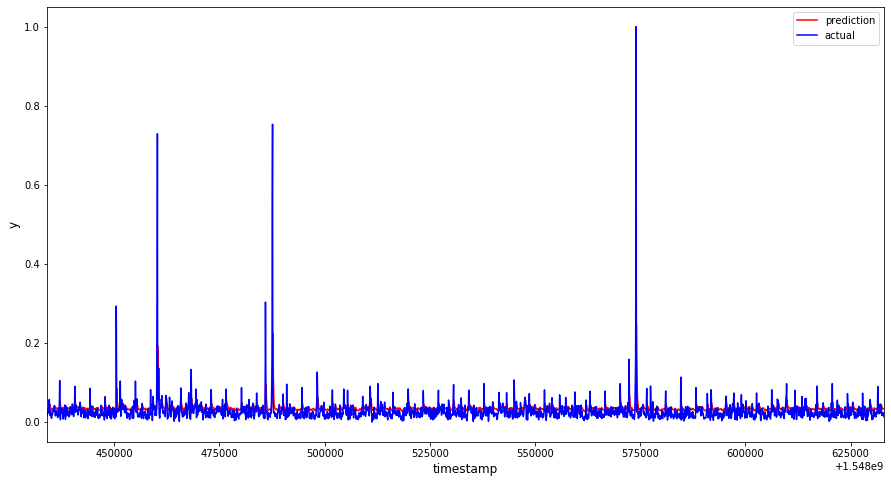

In [47]:
showComparsionGraph(merge_gussian_df)